# My Optimization Experiment

use scipy.optimize (L-BFGS-B)


In [1]:
%load_ext autoreload
%autoreload 2

from concurrent import futures
from datetime import datetime
from functools import partial
# import pandas_datareader as pdr
import pickle
import pytest
import warnings

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# optimizers
from scipy import optimize

from SWRsimulation.SWRsimulationCE import SWRsimulationCE
from SWRsimulation.crra_ce import crra_ce

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))

# turn off excessive warnings
warnings.filterwarnings("ignore")


numpy 1.24.3
pandas 2.0.2
scipy 1.10.1


In [2]:
# 1000 is generally more than enough for a decent solution
# optimizers sometimes ignore this and stop early anyway (or keep going if too small)
N_TRIALS = 5000


In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


### Load data

Data via Aswath Damodaran (thanks professor!)

http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html 

In [4]:
# load Damodaran data from pickle

RETURN_FILE = '../data/histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 16]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df


,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011561
1929,-0.082979,0.030179,0.005848
1930,-0.251236,0.005398,-0.063953
1931,-0.438375,-0.156808,-0.093168
1932,-0.086424,0.235896,-0.102740
...,...,...,...
2018,-0.042269,-0.027626,0.019102
2019,0.312117,0.153295,0.022851
2020,0.180232,0.104115,0.013620


In [5]:
# should adjust CPI to year-ending also but leave it for now (seems to be annual avg index vs prev year avg)
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454932,0.044268
1929,-0.088311,0.024189
1930,-0.200079,0.074090
1931,-0.380674,-0.070178
1932,0.018184,0.377411
...,...,...
2018,-0.060220,-0.045852
2019,0.282803,0.127529
2020,0.164373,0.089279


### Objective function to optimize 

In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
FLOOR_SPEND = 4
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    # global s   # for debugging keep last
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        floor_spend = params['floor_spend']
        alloc_stocks = params['alloc_stocks']
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, floor_spend, alloc_stocks = params     
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, floor_spend, alloc_stocks = params.tolist()
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    # optimization constraints should prevent trialing these values but just in case
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'floor_pct': floor_spend,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with functools.partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, FLOOR_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, FLOOR_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, FLOOR_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'floor_spend': FLOOR_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9977.447972813754
-9977.447972813754
-9977.447972813754
-9977.447972813754


In [7]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

# set floor to 0 and optimize with 1 less parameter
# lets some optimizers do better

def ce_experiment_nofloor(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    # global s   # for debugging keep last
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    # optimization constraints should prevent trialing these values but just in case
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'floor_pct': 0,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with functools.partial
ce_experiment_1 = partial(ce_experiment_nofloor, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9686.258131086823
-9686.258131086823
-9686.258131086823
-9686.258131086823


### scipy.optimize (L-BFGS-B)

In [8]:
results_dict = {}
timings_dict = {}


In [9]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

# initial guess
x0 = np.array([2.0, 2.0, 0.5])
method = 'L-BFGS-B'
optimizer = "scipy.optimize no floor (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment_nofloor, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time
    study_timings.append(time_elapsed.total_seconds())

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))
        

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['floor_spend'] = 0.0
results['gamma'] = study_gammas
results['value'] = study_values
results['runtime_secs'] = study_timings
results['optimizer'] = optimizer
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend', 'floor_spend', 
                   'value', 'runtime_secs', 'optimizer']]
results_dict[optimizer] = results.copy()
with open('results.pickle', 'wb') as handle:
    pickle.dump(results_dict, handle)
results

2023-08-23 21:21:22 Starting scipy.optimize no floor (L-BFGS-B), gamma 0, 5000 iterations max
2023-08-23 21:21:26 Finishing optimizer scipy.optimize no floor (L-BFGS-B), gamma 0, 8 iterations in 0:00:04.037461
2023-08-23 21:21:26 best value -16062.214180, best params [0.         6.21639097 1.        ]
2023-08-23 21:21:26 Starting scipy.optimize no floor (L-BFGS-B), gamma 1, 5000 iterations max
2023-08-23 21:22:24 Finishing optimizer scipy.optimize no floor (L-BFGS-B), gamma 1, 38 iterations in 0:00:57.578440
2023-08-23 21:22:24 best value -13952.879731, best params [0.32738036 6.21564377 1.        ]
2023-08-23 21:22:24 Starting scipy.optimize no floor (L-BFGS-B), gamma 2, 5000 iterations max
2023-08-23 21:22:54 Finishing optimizer scipy.optimize no floor (L-BFGS-B), gamma 2, 24 iterations in 0:00:30.144482
2023-08-23 21:22:54 best value -12398.172086, best params [2.02778706 4.42878056 1.        ]
2023-08-23 21:22:54 Starting scipy.optimize no floor (L-BFGS-B), gamma 4, 5000 iterations

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,floor_spend,value,runtime_secs,optimizer
0,0,1.000000,0.000000,0.000000,6.216391,0.0,-16062.214180,4.037461,scipy.optimize no floor (L-BFGS-B)
1,1,1.000000,0.000000,0.327380,6.215644,0.0,-13952.879731,57.578440,scipy.optimize no floor (L-BFGS-B)
2,2,1.000000,0.000000,2.027787,4.428781,0.0,-12398.172086,30.144482,scipy.optimize no floor (L-BFGS-B)
3,4,0.897889,0.102111,2.537808,3.295937,0.0,-10581.266210,29.795036,scipy.optimize no floor (L-BFGS-B)
4,6,0.817466,0.182534,2.939632,2.297469,0.0,-9796.763487,23.262016,scipy.optimize no floor (L-BFGS-B)
5,8,0.786095,0.213905,3.130590,1.850324,0.0,-9360.120032,43.383389,scipy.optimize no floor (L-BFGS-B)
6,10,0.751084,0.248916,3.241692,1.596010,0.0,-9085.236888,37.042821,scipy.optimize no floor (L-BFGS-B)
7,12,0.763620,0.236380,3.362333,1.328977,0.0,-8899.984696,22.533592,scipy.optimize no floor (L-BFGS-B)
8,14,0.714031,0.285969,3.410629,1.217935,0.0,-8759.607579,30.466128,scipy.optimize no floor (L-BFGS-B)
9,16,0.728142,0.271858,3.476890,1.076540,0.0,-8659.900238,55.714360,scipy.optimize no floor (L-BFGS-B)


In [10]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

# initial guess
x0 = np.array([0.0, 5.0, 3.0, 0.5])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    floor_max = 5
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, floor_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time
    study_timings.append(time_elapsed.total_seconds())

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))
        

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (datestr(), optimizer, time_elapsed))

results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'floor_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['runtime_secs'] = study_timings
results['optimizer'] = optimizer
results['alloc_bonds'] = 1-results['alloc_stocks']
results['optimizer'] = optimizer
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'floor_spend', 'variable_spend', 
                   'value', 'optimizer', 'runtime_secs',]]
results_dict[optimizer] = results.copy()
with open('results.pickle', 'wb') as handle:
    pickle.dump(results_dict, handle)
results

2023-08-23 21:27:12 Starting scipy.optimize (L-BFGS-B), gamma 0, 5000 iterations max
2023-08-23 21:27:37 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 14 iterations in 0:00:24.792026
2023-08-23 21:27:37 best value -16100.931137, best params [0.         6.30616952 3.4611011  1.        ]
2023-08-23 21:27:37 Starting scipy.optimize (L-BFGS-B), gamma 1, 5000 iterations max
2023-08-23 21:28:18 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 30 iterations in 0:00:41.466691
2023-08-23 21:28:18 best value -14127.391090, best params [0.         6.54259247 3.39184631 1.        ]
2023-08-23 21:28:18 Starting scipy.optimize (L-BFGS-B), gamma 2, 5000 iterations max
2023-08-23 21:28:56 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 16 iterations in 0:00:37.774421
2023-08-23 21:28:56 best value -12454.008756, best params [0.7061215  5.73352888 3.36741225 0.99305649]
2023-08-23 21:28:56 Starting scipy.optimize (L-BFGS-B), gamma 4, 5000 iterations max
2023-08-23 21:29:37 Fini

,gamma,alloc_stocks,alloc_bonds,fixed_spend,floor_spend,variable_spend,value,optimizer,runtime_secs
0,0,1.000000,0.000000,0.000000,3.461101,6.306170,-16100.931137,scipy.optimize (L-BFGS-B),24.792026
1,1,1.000000,0.000000,0.000000,3.391846,6.542592,-14127.391090,scipy.optimize (L-BFGS-B),41.466691
2,2,0.993056,0.006944,0.706122,3.367412,5.733529,-12454.008756,scipy.optimize (L-BFGS-B),37.774421
3,4,0.904735,0.095265,0.438409,3.587348,5.489519,-10407.252177,scipy.optimize (L-BFGS-B),40.590638
4,6,0.829316,0.170684,0.063883,3.907862,4.851941,-9611.605034,scipy.optimize (L-BFGS-B),61.247827
5,8,0.741515,0.258485,0.084840,3.905622,4.877456,-9155.373143,scipy.optimize (L-BFGS-B),43.951889
6,10,0.790634,0.209366,1.344454,3.939809,3.264734,-8919.916743,scipy.optimize (L-BFGS-B),67.269515
7,12,0.775845,0.224155,0.843762,3.969634,3.639635,-8742.551963,scipy.optimize (L-BFGS-B),66.165627
8,14,0.772128,0.227872,1.978006,3.954895,2.480857,-8627.854988,scipy.optimize (L-BFGS-B),49.513358
9,16,0.783965,0.216035,2.129586,3.965910,2.256995,-8537.244973,scipy.optimize (L-BFGS-B),101.653864


Simulation:
{'n_asset_years': 95,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454932  0.044268
1929 -0.088311  0.024189
1930 -0.200079  0.074090
1931 -0.380674 -0.070178
1932  0.018184  0.377411
...        ...       ...
2018 -0.060220 -0.045852
2019  0.282803  0.127529
2020  0.164373  0.089279
2021  0.199522 -0.057578
2022 -0.229552 -0.196470

[95 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x151112880>}

Allocation:
{'asset_weights': array([0.78396523, 0.21603477])}

Withdrawal:
{'fixed': 2.1295864521633057,
 'fixed_pct': 2.1295864521633057,
 'floor': 3.965909866487756,
 'floor_pct': 3.9659098664877557,
 'variable': 0.022569954988983024,
 'variable_pct': 2.2569954988983025}


,metric,value
0,mean annual spending over all cohorts,5.95593454
1,mean within-cohort standard deviation of spending,1.26357371
2,lowest annual spending over all cohorts,3.55287049
3,minimum ending portfolio over all cohorts,0.00000000
4,% cohort portfolios exhausted by final year,1.51515152


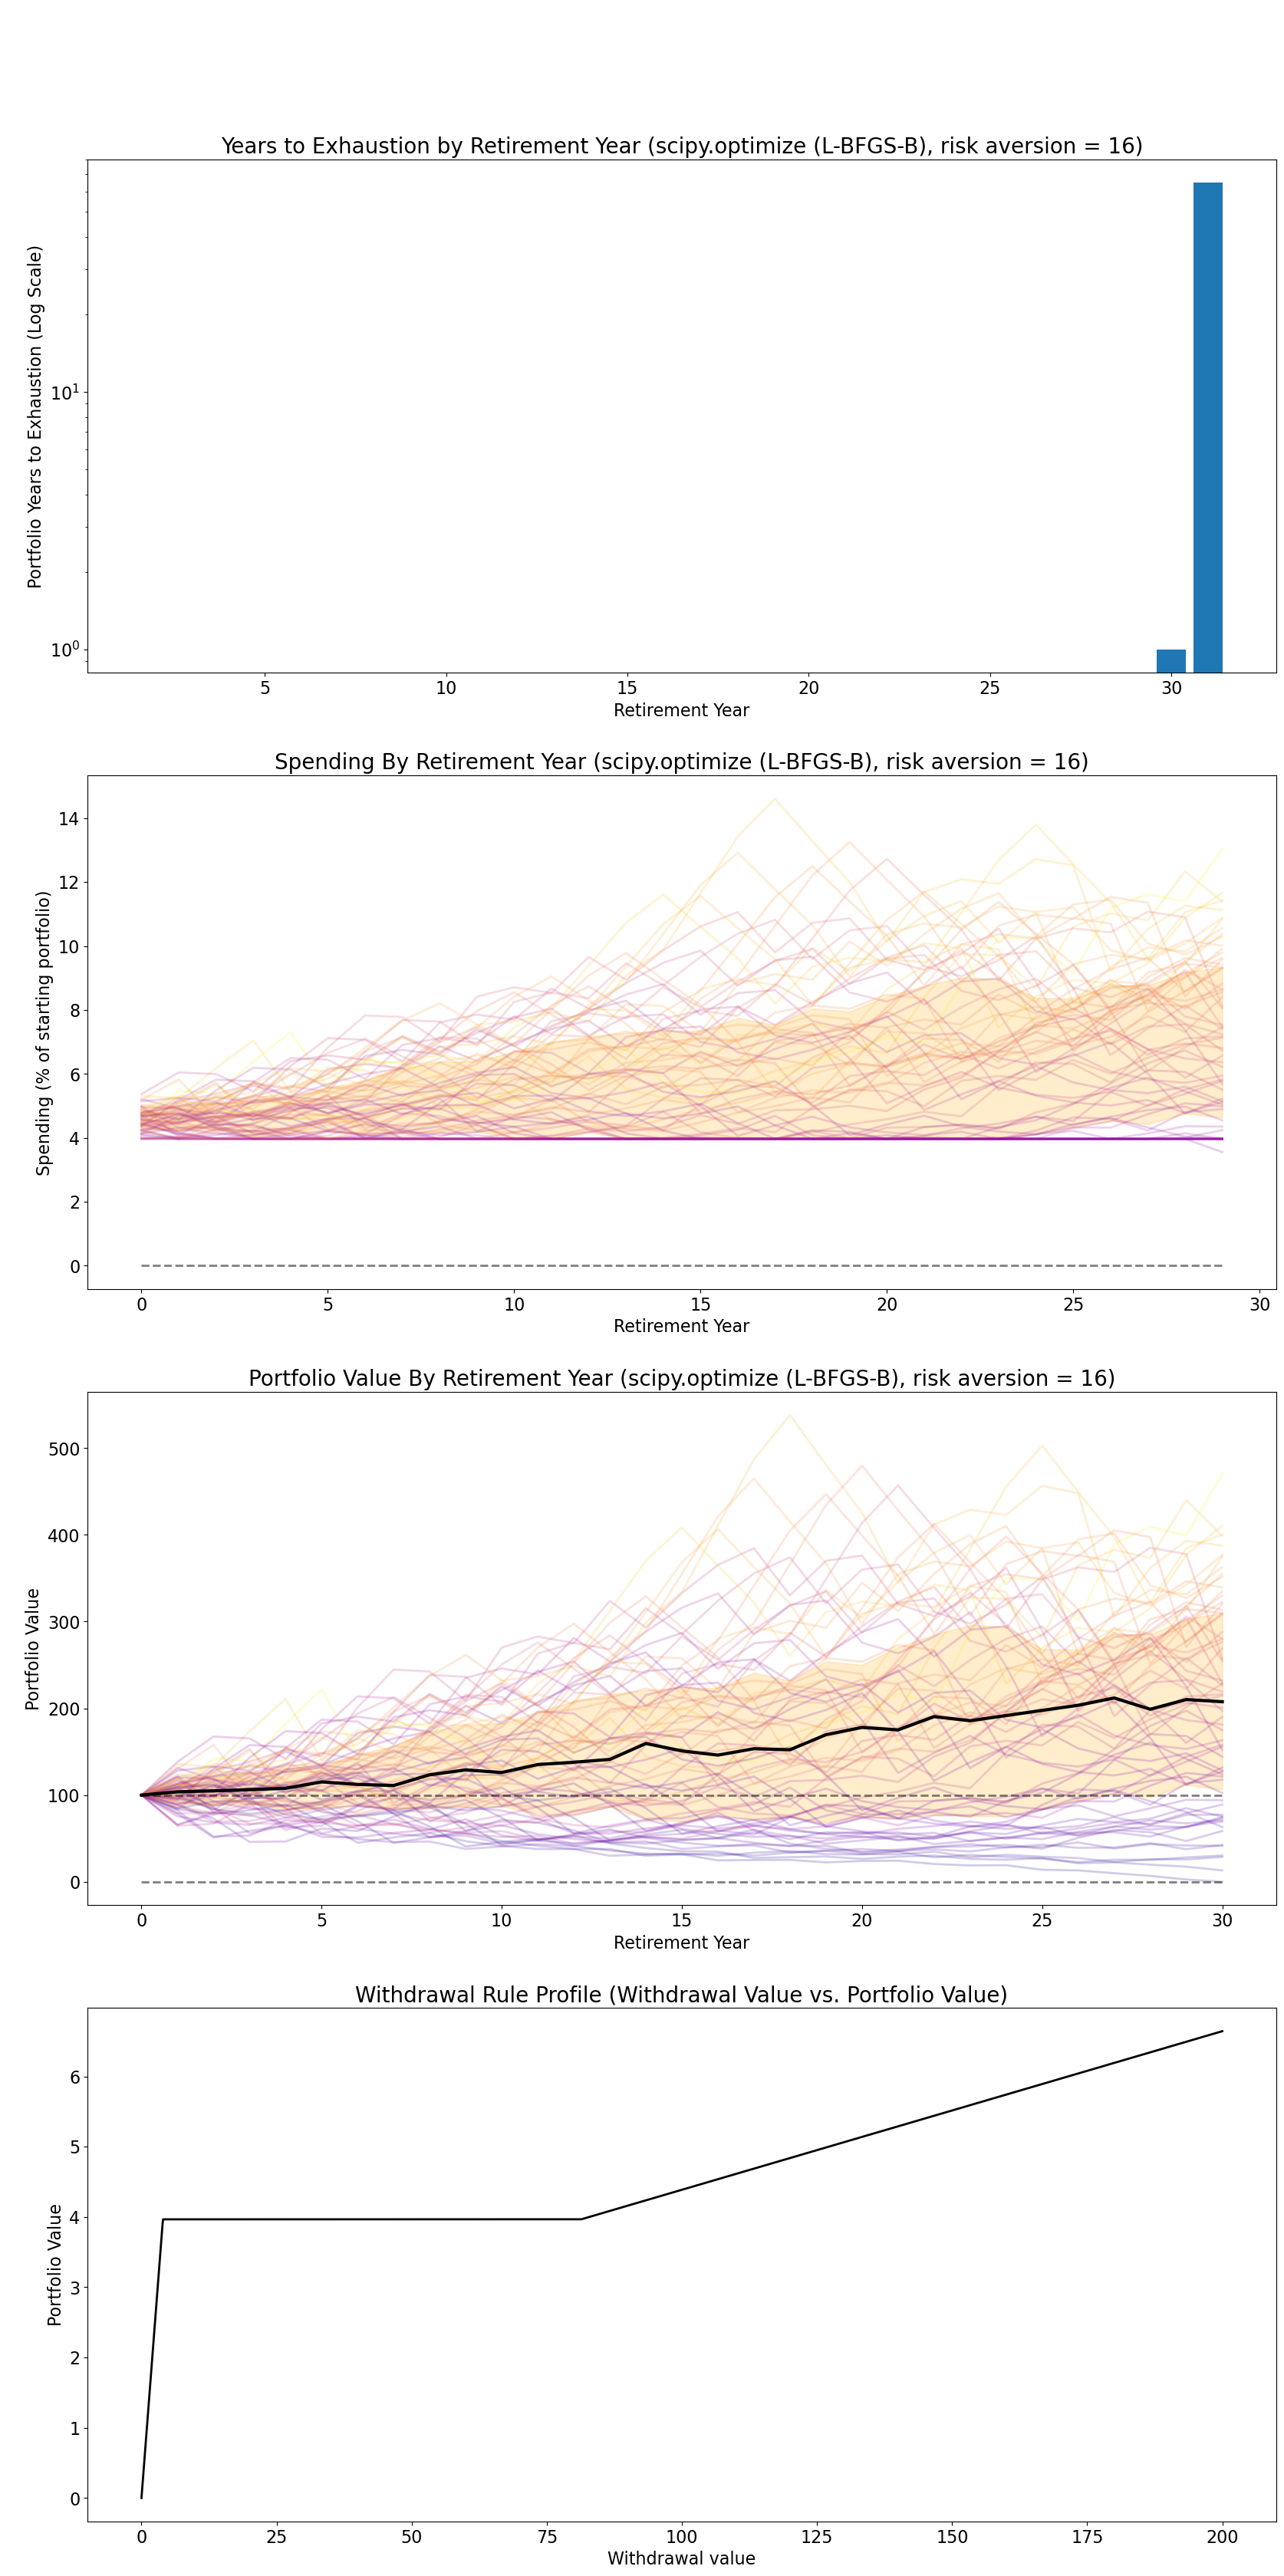

In [11]:
def run_strategy(resultsrow, verbose=True):

    FIXED_SPEND = resultsrow.fixed_spend
    VARIABLE_SPEND = resultsrow.variable_spend
    FLOOR_SPEND = resultsrow.floor_spend
    ALLOC_STOCKS = resultsrow.alloc_stocks
    ALLOC_BONDS = 1 - ALLOC_STOCKS
    GAMMA = resultsrow.gamma
    N_RET_YEARS = 30

    s = SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': N_RET_YEARS,
                      },
        'allocation': {'asset_weights': np.array([ALLOC_STOCKS, ALLOC_BONDS])}, # default is equal-weight 
        'withdrawal': {'fixed_pct': FIXED_SPEND,
                       'variable_pct': VARIABLE_SPEND,
                       'floor_pct': FLOOR_SPEND},
        
        'evaluation': {'gamma': GAMMA},
        'visualization': {'histogram': True, 
                          'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (resultsrow.optimizer, GAMMA),
                                       'annotation': "Floor %.1f, Fixed spend %.1f, Variable spend %.1f, Stocks %.1f%%" % \
                                       (FLOOR_SPEND, FIXED_SPEND, VARIABLE_SPEND, 100 * ALLOC_STOCKS),
                                      },
                          'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (resultsrow.optimizer, GAMMA),
                                      },
                          'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (resultsrow.optimizer, GAMMA),
                                      },
                         }    
    })
    
    if verbose:
        print(s)

    s.simulate()

    return s
    
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method
results['optimizer'] = optimizer
run_strategy(results.iloc[-1]).visualize()


In [12]:
s0 = run_strategy(results.iloc[0], verbose=False)
# check one iteration
print("%-20s %.6f" % ('mean_spend', s0.latest_simulation[0]['mean_spend']))
print("%-20s %.6f" % ('mean of spend', s0.latest_simulation[0]['trial']['spend'].mean()))
print("%-20s %.6f" % ('ce_spend', s0.latest_simulation[0]['ce_spend'] / N_RET_YEARS))
print("%-20s %.6f" % ('ce of spend', crra_ce(s0.latest_simulation[0]['trial']['spend'], 0) / N_RET_YEARS))
# -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), 0)

# check all iterations
print("%-20s %.6f" % ("mean of mean_spend", np.mean([z['mean_spend'] for z in s0.latest_simulation])))
print("%-20s %.6f" % ("mean of ce_spend", np.mean([z['ce_spend'] for z in s0.latest_simulation]) / N_RET_YEARS))
print("%-20s %.6f" % ("total ce_spend", crra_ce(np.array([z['ce_spend'] for z in s0.latest_simulation]), 0) / N_RET_YEARS / (len(real_return_df) - N_RET_YEARS + 1)))


mean_spend           4.605382
mean of spend        4.605382
ce_spend             4.605382
ce of spend          4.605382
mean of mean_spend   8.131783
mean of ce_spend     8.131783
total ce_spend       8.131783
